<a href="https://colab.research.google.com/github/azimdaiana/transitive-inference/blob/main/transitive_inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**libraries**

In [ ]:
import torch as torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
import torch.distributions as dist
import pandas as pd
import seaborn as sns
from google.colab import files
from textwrap import wrap

palette1 = sns.color_palette(["#274E13", "#1e5631", "#4c9a2a", "#76ba1b",  "#68bb59", "#a4de02",  '#acdf87'])
palette2 = sns.color_palette(["#274E13", "#800020"])
palette3 = sns.color_palette(['#acdf87', "#68bb59", "#4c9a2a", "#274E13"])

**matrix**

In [ ]:
def item(i,j,n):
      num1 = torch.tensor([0] * n)
      num2 = torch.tensor([0] * n)
      num1[i] = 1
      num2[j] = 1
      return torch.cat((num1, num2)).float()

**train dataset**

In [ ]:
def ti_train(n):
    xlist = []
    ylist = []

    for i in range(n-1):
        xlist.append(item(i, i+1, n))
        xlist.append(item(i+1, i, n))
        ylist.append(1.)
        ylist.append(-1.)

    return torch.stack(xlist), torch.tensor(ylist)

**test dataset**

In [ ]:
def ti_test(n):
  ilist = []
  jlist = []

  for i in range(n):
    jlist = []
    for j in range(n):
      jlist.append(item(i, j, n))
    ilist.append(torch.stack(jlist))
  return torch.stack(ilist)

**single datapoint**

In [ ]:
def responses(model, n):
  ilist = []
  jlist = []
  response = []
  for i in range(n):
    for j in range(n):
      ilist.append(i)
      jlist.append(j)
      x = item(i, j, n)
      x = function(x.float()).detach().clone() #applies linear trans
      x = torch.relu(x) #applies non-linear trans
      response.append(model(x)[0].item())
  df_responses = pd.DataFrame({'i': ilist, 'j': jlist, 'response': response})
  return df_responses

**repoducibility & random**

In [ ]:
torch.manual_seed(3)
shape = (4,6)
normal_dist = dist.Normal(torch.tensor(0.0), torch.tensor(1.0))
normal_dist.sample(shape)

tensor([[-0.0766,  0.3599, -0.7820,  0.0715,  0.6648, -0.2868],
        [ 1.6206, -1.5967,  0.4046,  0.6113,  0.7604, -0.0336],
        [-0.3448,  0.4937, -0.0776, -1.8054,  0.4851,  0.2052],
        [ 0.3384,  1.3528,  0.3736,  0.0134,  0.7737, -0.1092]])

**representation**

In [ ]:
n = 7

In [ ]:
function = nn.Linear(ti_train(n)[0].size(1), 1000)
rep_train = function(ti_train(n)[0].float()).detach().clone() #applies linear trans
rep_train = torch.relu(rep_train) #applies non-linear trans
rep_test = function(ti_test(n).float()).detach().clone()
rep_test = torch.relu(rep_test)

curricula

In [ ]:
ti_list = []
for i in range(n-1):
    ti_list.append([i, i+1])
    ti_list.append([i+1, i])
ti_list = ti_list * 1000

**transitive inference w ReLU**

In [ ]:
y = ti_train(n)[1] #teacher
model = nn.Linear(1000, 1) #student/model
nn.init.zeros_(model.weight)
loss_list = []
step = 0
dfs = []
optimizer = optim.SGD(model.parameters(), lr=0.01)

for (i, j) in ti_list:
  optimizer.zero_grad() #removes existing gradients

  x = item(i, j, n)
  x = function(x.float()).detach().clone() #applies linear trans
  x = torch.relu(x) #applies non-linear trans
  yhat = model(x)
  df = responses(model, n)
  df['step'] = step
  dfs.append(df)
  step += 1
  if i < j:
    y = torch.tensor(1.)
  if j < i:
    y = torch.tensor(-1.)

  loss = torch.mean((yhat - y) ** 2) #the loss function optimizes the student model by decreasing the mean tensor so the output is closest to that of the teacher
  loss.backward() #finds the gradient
  optimizer.step()#updates the parameter; changes the weight based on the gradient

  loss_list.append(loss.detach()) #records the loss value

In [ ]:
df_ti = pd.concat(dfs).reset_index(drop=True)
df_ti['name'] = df_ti.apply(lambda row: (chr(ord('@') + int(row['i']) + 1)) + (chr(ord('@') + int(row['j']) + 1)), axis=1)
df_ti['order'] = np.where(df_ti['j'] > df_ti['i'], 'ascending', 'descending')

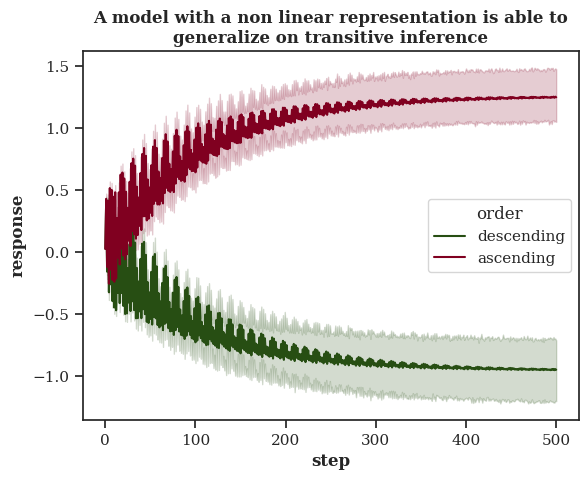

In [ ]:
sns.set_theme(style='ticks', font="serif", palette = palette2)
title = "A model with a non linear representation is able to generalize on transitive inference"
wrapped_title = '\n'.join(wrap(title, 60))
fig = sns.lineplot(x="step", y="response", hue="order", data=df_ti[df_ti['step'] <=500])
fig.set_title(wrapped_title, fontdict={'weight': 'bold'})
fig.set_xlabel('step', fontweight="bold")
fig.set_ylabel('response',fontweight="bold")
plt.savefig('filename.png', dpi=1200)

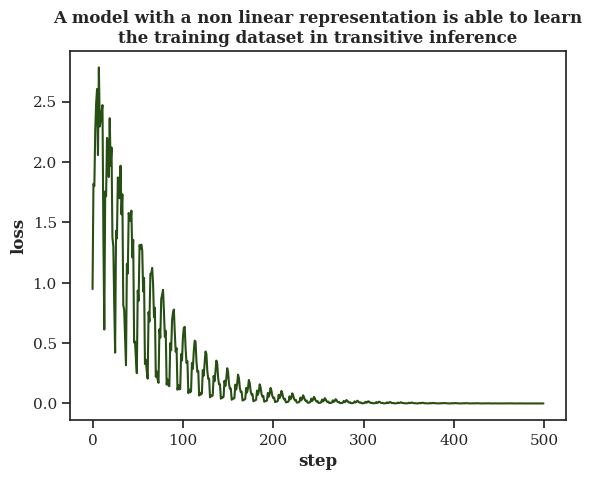

In [ ]:
plt.plot(loss_list[:500], c = '#274E13')
title = "A model with a non linear representation is able to learn the training dataset in transitive inference"
wrapped_title = '\n'.join(wrap(title, 60))
plt.title(wrapped_title, fontfamily = 'serif', fontweight='bold')
plt.xlabel('step', fontfamily = 'serif', fontweight='bold')
plt.ylabel("loss", fontfamily = 'serif', fontweight='bold')
plt.savefig('filename.png', dpi=1200)

**transitive inference w/o ReLU**

In [ ]:
y = ti_train(n)[1] #teacher
model = nn.Linear(1000, 1) #student/model
nn.init.zeros_(model.weight)
loss_list = []
step = 0
dfs = []
optimizer = optim.SGD(model.parameters(), lr=0.01)

for (i, j) in ti_list:
  optimizer.zero_grad() #removes existing gradients

  x = item(i, j, n)
  x = function(x.float()).detach().clone() #applies linear trans
  yhat = model(x)
  df = responses(model, n)
  df['step'] = step
  dfs.append(df)
  step += 1
  if i < j:
    y = torch.tensor(1.)
  if j < i:
    y = torch.tensor(-1.)

  loss = torch.mean((yhat - y) ** 2) #the loss function optimizes the student model by decreasing the mean tensor so the output is closest to that of the teacher
  loss.backward() #finds the gradient
  optimizer.step()#updates the parameter; changes the weight based on the gradient

  loss_list.append(loss.detach()) #records the loss value

df_ti = pd.concat(dfs).reset_index(drop=True)
df_ti['name'] = df_ti.apply(lambda row: (chr(ord('@') + int(row['i']) + 1)) + (chr(ord('@') + int(row['j']) + 1)), axis=1)
df_ti['order'] = np.where(df_ti['j'] > df_ti['i'], 'ascending', 'descending')
df_ti['order'] = np.where(df_ti['j'] > df_ti['i'], 'ascending', 'descending')

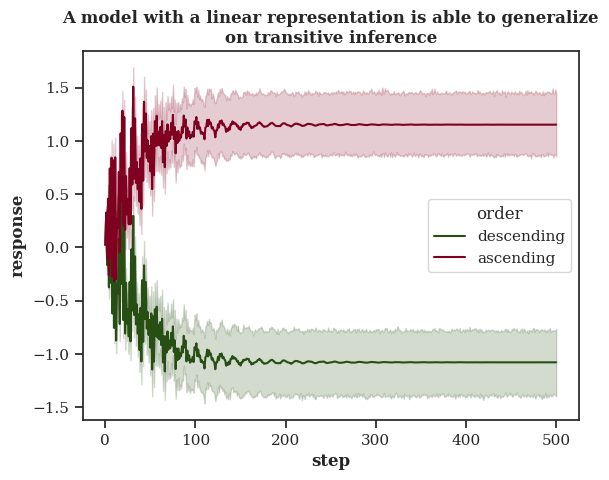

In [ ]:
sns.set_theme(style='ticks', font="serif", palette=palette2)
title = "A model with a linear representation is able to generalize on transitive inference"
wrapped_title = '\n'.join(wrap(title, 60))
fig = sns.lineplot(x="step", y="response", hue="order", data=df_ti[df_ti['step'] <=500])
fig.set_title(wrapped_title, fontdict={'weight': 'bold'})
fig.set_xlabel('step', fontweight="bold")
fig.set_ylabel('response',fontweight="bold")
plt.savefig('filename.png', dpi=1200)

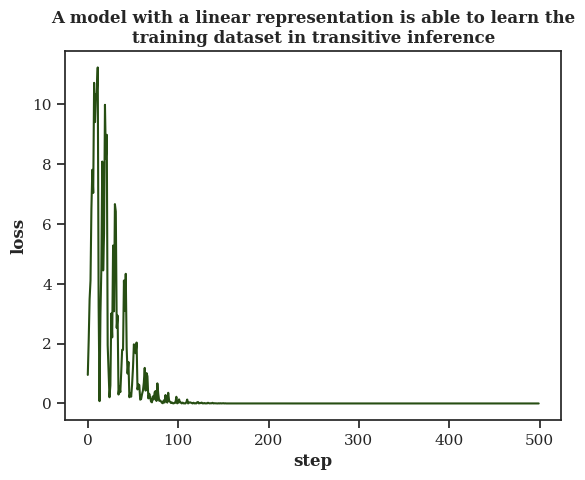

In [ ]:
plt.plot(loss_list[:500], c = '#274E13')
title = "A model with a linear representation is able to learn the training dataset in transitive inference"
wrapped_title = '\n'.join(wrap(title, 60))
plt.title(wrapped_title, fontfamily = 'serif', fontweight='bold')
plt.xlabel('step', fontfamily = 'serif', fontweight='bold')
plt.ylabel("loss", fontfamily = 'serif', fontweight='bold')
plt.savefig('filename.png', dpi=1200)

**transverse patterning w ReLU**

In [ ]:
function = nn.Linear(ti_train(n)[0].size(1), 5000)
rep_train = function(ti_train(n)[0].float()).detach().clone() #applies linear trans
rep_train = torch.relu(rep_train) #applies non-linear trans
rep_test = function(ti_test(n).float()).detach().clone()
rep_test = torch.relu(rep_test)
list = [(0,1), (1,0), (1,2), (2,1), (0,2), (2,0)]
list = list * 1000
y=0

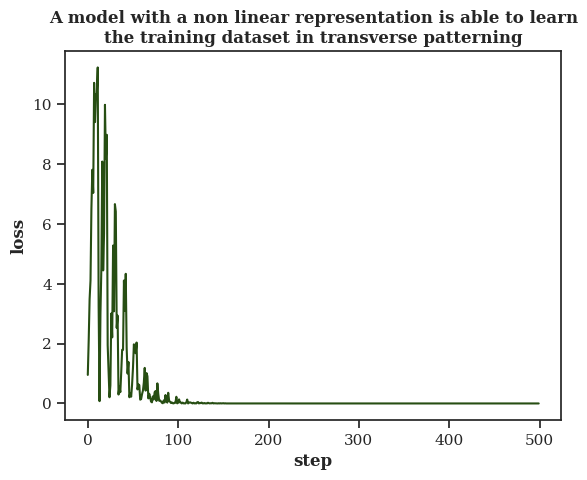

In [ ]:
plt.plot(loss_list[:500], c = '#274E13')
title = "A model with a non linear representation is able to learn the training dataset in transverse patterning"
wrapped_title = '\n'.join(wrap(title, 60))
plt.title(wrapped_title, fontfamily = 'serif', fontweight='bold')
plt.xlabel('step', fontfamily = 'serif', fontweight='bold')
plt.ylabel("loss", fontfamily = 'serif', fontweight='bold')
plt.savefig('filename.png', dpi=1200)

**transitive inference w/o ReLU**

In [ ]:
model = nn.Linear(5000, 1) #student/model
nn.init.zeros_(model.weight)
loss_list = []

optimizer = optim.SGD(model.parameters(), lr=0.001)

for (i, j) in list:
  optimizer.zero_grad() #removes existing gradients

  x = item(i, j, n)
  x = function(x.float()).detach().clone() #applies linear trans
  yhat = model(x)
  if (i,j) == (0,2):
    y = -1
  elif (i,j) == (2,0):
    y = 1
  elif i>j:
    y = -1
  elif j>i:
    y = 1

  loss = torch.mean((yhat - y) ** 2) #the loss function optimizes the student model by decreasing the mean tensor so the output is closest to that of the teacher
  loss.backward() #finds the gradient
  optimizer.step()#updates the parameter; changes the weight based on the gradient

  loss_list.append(loss.detach()) #records the loss value

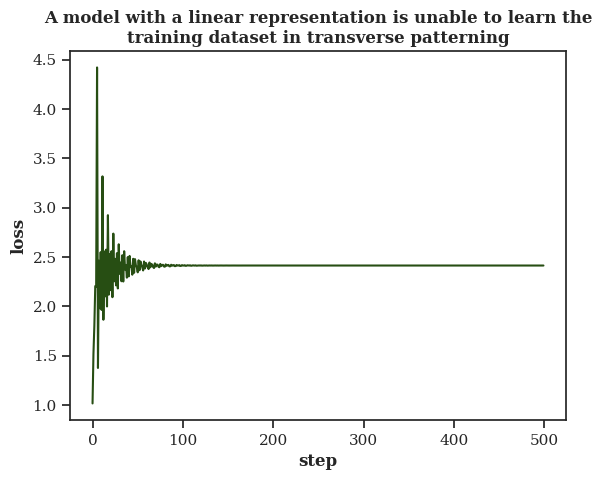

In [ ]:
plt.plot(loss_list[:500], c = '#274E13')
title = "A model with a linear representation is unable to learn the training dataset in transverse patterning"
wrapped_title = '\n'.join(wrap(title, 60))
plt.title(wrapped_title, fontfamily = 'serif', fontweight='bold')
plt.xlabel('step', fontfamily = 'serif', fontweight='bold')
plt.ylabel("loss", fontfamily = 'serif', fontweight='bold')
plt.savefig('filename.png', dpi=1200)



---



**curriculum learning**

In [ ]:
function = nn.Linear(ti_train(n)[0].size(1), 1000)
rep_train = function(ti_train(n)[0].float()).detach().clone() #applies linear trans
rep_train = torch.relu(rep_train) #applies non-linear trans
rep_test = function(ti_test(n).float()).detach().clone()
rep_test = torch.relu(rep_test)

ti_rank

In [ ]:
def ti_rank(ti_list):
  #Transitive Inference
  y = ti_train(n)[1] #teacher
  model = nn.Linear(1000, 1) #student/model
  nn.init.zeros_(model.weight)
  loss_list = []
  step = 0
  dfs = []
  optimizer = optim.SGD(model.parameters(), lr=0.01)

  for (i, j) in ti_list:
    optimizer.zero_grad() #removes existing gradients

    x = item(i, j, n)
    x = function(x.float()).detach().clone() #applies linear trans
    x = torch.relu(x) #applies non-linear trans
    yhat = model(x)
    df = responses(model, n)
    df['step'] = step
    dfs.append(df)
    step += 1
    if i < j:
      y = torch.tensor(1.)
    if j < i:
      y = torch.tensor(-1.)

    loss = torch.mean((yhat - y) ** 2) #the loss function optimizes the student model by decreasing the mean tensor so the output is closest to that of the teacher
    loss.backward() #finds the gradient
    optimizer.step()#updates the parameter; changes the weight based on the gradient

    loss_list.append(loss.detach()) #records the loss value

  df_ti = pd.concat(dfs).reset_index(drop=True)
  df_ti['name'] = df_ti.apply(lambda row: (chr(ord('@') + int(row['i']) + 1)) + (chr(ord('@') + int(row['j']) + 1)), axis=1)
  df_ti = df_ti.copy()
  df_tisub = df_ti[~((np.where(df_ti['j'] != df_ti['i'] + 1, False, True)) | (np.where(df_ti['j'] != df_ti['i'] - 1, False, True)))]
  df_tisub = df_tisub.copy()
  return df_tisub

all_rank

In [ ]:
def all_rank(df_tisub):
  #left
  step = 0
  left1 = []
  df_left = pd.DataFrame()
  for step in range(12000):
    input = []
    df_sub = df_tisub[df_tisub['step'] == step]
    for i_it, j_it in zip(df_sub['i'], df_sub['j']):
      input.append(item(i_it, j_it, n))
    x = torch.stack(input)
    y = df_sub['response'].values
    model = LinearRegression().fit(x, y)
    w = model.coef_
    left = w[:7]
    df_left_rank = pd.DataFrame({'rank': left})
    df_left_rank['step'] = step
    df_left_rank['item'] = range(len(left))
    df_left_rank['side'] = 'left'
    df_left = pd.concat([df_left, df_left_rank], ignore_index=True)
    df_left = df_left.copy()

  #right
  step = 0
  right1 = []
  df_right = pd.DataFrame()
  for step in range(12000):
    input = []
    df_sub = df_tisub[df_tisub['step'] == step]
    for i_it, j_it in zip(df_sub['i'], df_sub['j']):
        input.append(item(i_it, j_it, n))
    x = torch.stack(input)
    y = df_sub['response'].values
    model = LinearRegression().fit(x, y)
    w = model.coef_
    right = -w[7:14]
    df_right_rank = pd.DataFrame({'rank': right})
    df_right_rank['step'] = step
    df_right_rank['item'] = range(len(right))
    df_right_rank['side'] = 'right'
    df_right = pd.concat([df_right, df_right_rank], ignore_index=True)
    df_right = df_right.copy()

  df_rank = pd.concat([df_right, df_left], axis=0)
  df_rank['item'] = df_rank.apply(lambda row: chr(ord('@') + int(row['item']) + 1), axis=1)
  df_rank = df_rank.copy()
  return df_left, df_right, df_rank

standard

In [ ]:
#1: standard
ti_list1 = [[0, 1], [1, 0], [1, 2], [2, 1], [2, 3], [3, 2], [3, 4], [4, 3], [4, 5], [5, 4], [5, 6], [6, 5]]
ti_list1 = ti_list1 * 1000

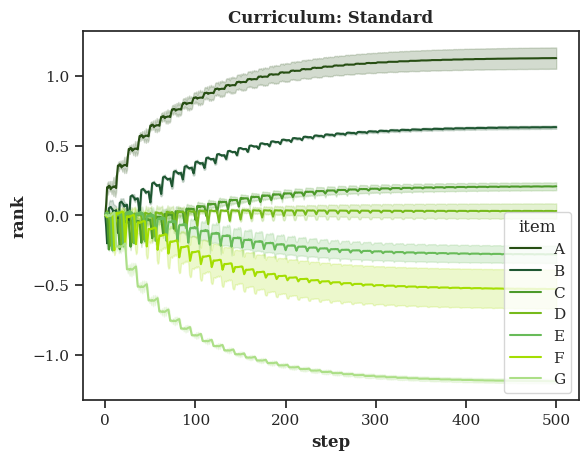

In [ ]:
df_tisub = ti_rank(ti_list1)
df_rank = all_rank(df_tisub)[2]
sns.set_theme(style='ticks', font="serif", palette=palette1)
title = "Curriculum: Standard"
wrapped_title = '\n'.join(wrap(title, 60))
fig = sns.lineplot(x="step", y="rank", hue="item", data = df_rank[df_rank['step'] <= 500])
fig.set_title(wrapped_title, fontdict={'weight': 'bold'})
fig.set_xlabel('step', fontweight="bold")
fig.set_ylabel('rank',fontweight="bold")
plt.savefig('filename.png', dpi=1200)

In [ ]:
# @title
@title
df_left = all_rank(df_tisub)[0]
df_right = all_rank(df_tisub)[1]
df_lstep = df_left[np.isin(df_left['step'],[1, 10, 100, 1000])]
df_rstep = df_right[np.isin(df_right['step'],[1, 10, 100, 1000])]
title = "The model's rank over training (standard curricula)"
wrapped_title = '\n'.join(wrap(title, 60))
sns.lineplot(data = df_lstep, x = 'item', y = 'rank', hue='step', palette = palette1, linestyle='--')
fig = sns.lineplot(data = df_rstep, x = 'item', y = 'rank', hue = 'step', palette = palette1).set_title(wrapped_title)
fig.set_title(wrapped_title, fontdict={'weight': 'bold'})
fig.set_xlabel('item', fontweight="bold")
fig.set_ylabel('rank',fontweight="bold")
plt.savefig('filename.png', dpi=1200)

outside-in

In [ ]:
#2: outside-in
ti_list2 = [[0, 1], [1, 0], [1, 2], [2, 1]]*10 + [[4, 5], [5, 4], [5, 6], [6, 5]]*10 + [[2, 3], [3, 2], [3, 4], [4, 3]] * 10
ti_list2 = ti_list2 *100

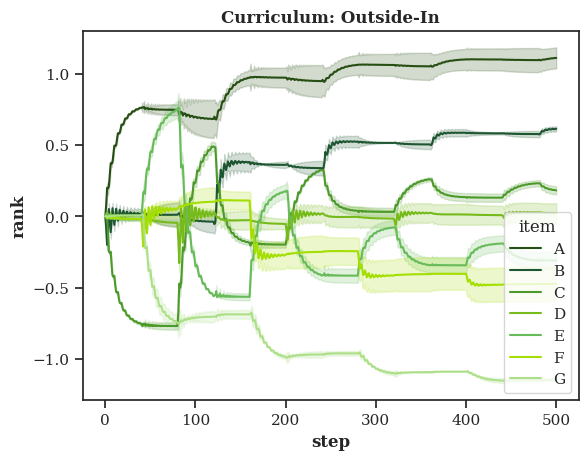

In [ ]:
df_tisub = ti_rank(ti_list2)
df_rank = all_rank(df_tisub)[2]
sns.set_theme(style='ticks', font="serif", palette=palette1)
title = "Curriculum: Outside-In"
wrapped_title = '\n'.join(wrap(title, 60))
fig = sns.lineplot(x="step", y="rank", hue="item", data = df_rank[df_rank['step'] <= 500])
fig.set_title(wrapped_title, fontdict={'weight': 'bold'})
fig.set_xlabel('step', fontweight="bold")
fig.set_ylabel('rank',fontweight="bold")
plt.savefig('filename.png', dpi=1200)

In [ ]:
df_left = all_rank(df_tisub)[0]
df_right = all_rank(df_tisub)[1]
df_lstep = df_left[np.isin(df_left['step'],[1, 10, 100, 1000])]
df_rstep = df_right[np.isin(df_right['step'],[1, 10, 100, 1000])]
title = "The model's rank over training (outside-in curricula)"
wrapped_title = '\n'.join(wrap(title, 60))
sns.lineplot(data = df_lstep, x = 'item', y = 'rank', hue='step', palette = palette1, linestyle='--')
fig = sns.lineplot(data = df_rstep, x = 'item', y = 'rank', hue = 'step', palette = palette1).set_title(wrapped_title)
fig.set_title(wrapped_title, fontdict={'weight': 'bold'})
fig.set_xlabel('item', fontweight="bold")
fig.set_ylabel('rank',fontweight="bold")
plt.savefig('filename.png', dpi=1200)

inside-out

In [ ]:
#3: inside-out
ti_list3 = [[2, 3], [3, 2], [3, 4], [4, 3]]*10 + [[0, 1], [1, 0], [1, 2], [2, 1]]*10 + [[4, 5], [5, 4], [5, 6], [6, 5]] * 10
ti_list3 = ti_list3 * 100

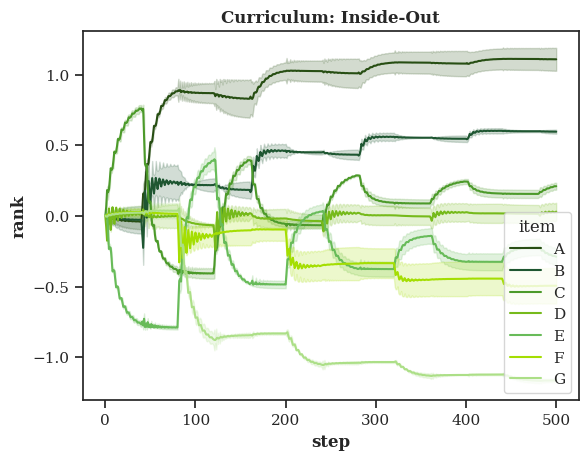

In [ ]:
df_tisub = ti_rank(ti_list3)
df_rank = all_rank(df_tisub)[2]
sns.set_theme(style='ticks', font="serif", palette=palette1)
title = "Curriculum: Inside-Out"
wrapped_title = '\n'.join(wrap(title, 60))
fig = sns.lineplot(x="step", y="rank", hue="item", data = df_rank[df_rank['step'] <= 500])
fig.set_title(wrapped_title, fontdict={'weight': 'bold'})
fig.set_xlabel('step', fontweight="bold")
fig.set_ylabel('rank',fontweight="bold")
plt.savefig('filename.png', dpi=1200)

In [ ]:
df_left = all_rank(df_tisub)[0]
df_right = all_rank(df_tisub)[1]
df_lstep = df_left[np.isin(df_left['step'],[1, 10, 100, 1000])]
df_rstep = df_right[np.isin(df_right['step'],[1, 10, 100, 1000])]
title = "The model's rank over training (inside-out curricula)"
wrapped_title = '\n'.join(wrap(title, 60))
sns.lineplot(data = df_lstep, x = 'item', y = 'rank', hue='step', palette = palette1, linestyle='--')
fig = sns.lineplot(data = df_rstep, x = 'item', y = 'rank', hue = 'step', palette = palette1).set_title(wrapped_title)
fig.set_title(wrapped_title, fontdict={'weight': 'bold'})
fig.set_xlabel('item', fontweight="bold")
fig.set_ylabel('rank',fontweight="bold")
plt.savefig('filename.png', dpi=1200)

reverse

In [ ]:
#4: reverse
ti_list4 = [[6, 5], [5, 6], [5, 4], [4, 5], [4, 3], [3, 4], [3, 2], [2, 3], [2, 1], [1, 2], [1, 0], [0, 1]]
ti_list4 = ti_list4 * 1000

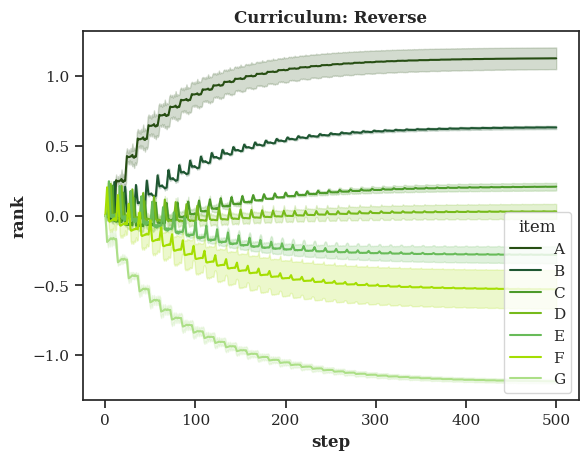

In [ ]:
df_tisub = ti_rank(ti_list4)
df_rank = all_rank(df_tisub)[2]
sns.set_theme(style='ticks', font="serif", palette=palette1)
title = "Curriculum: Reverse"
wrapped_title = '\n'.join(wrap(title, 60))
fig = sns.lineplot(x="step", y="rank", hue="item", data = df_rank[df_rank['step'] <= 500])
fig.set_title(wrapped_title, fontdict={'weight': 'bold'})
fig.set_xlabel('step', fontweight="bold")
fig.set_ylabel('rank',fontweight="bold")
plt.savefig('filename.png', dpi=1200)

In [ ]:
df_left = all_rank(df_tisub)[0]
df_right = all_rank(df_tisub)[1]
df_lstep = df_left[np.isin(df_left['step'],[1, 10, 100, 1000])]
df_rstep = df_right[np.isin(df_right['step'],[1, 10, 100, 1000])]
title = "The model's rank over training (reverse curricula)"
wrapped_title = '\n'.join(wrap(title, 60))
sns.lineplot(data = df_lstep, x = 'item', y = 'rank', hue='step', palette = palette1, linestyle='--')
fig = sns.lineplot(data = df_rstep, x = 'item', y = 'rank', hue = 'step', palette = palette1).set_title(wrapped_title)
fig.set_title(wrapped_title, fontdict={'weight': 'bold'})
fig.set_xlabel('item', fontweight="bold")
fig.set_ylabel('rank',fontweight="bold")
plt.savefig('filename.png', dpi=1200)

model_rank

In [ ]:
def model_rank(step, df_tisub, curricula):
  #left
  left1 = []
  df_left = pd.DataFrame()
  input = []
  df_sub = df_tisub[df_tisub['step'] == step]
  for i_it, j_it in zip(df_sub['i'], df_sub['j']):
    input.append(item(i_it, j_it, n))
  x = torch.stack(input)
  y = df_sub['response'].values
  model = LinearRegression().fit(x, y)
  w = model.coef_
  left = w[:7]
  df_left_rank = pd.DataFrame({'rank': left})
  df_left_rank['step'] = step
  df_left_rank['item'] = range(len(left))
  df_left_rank['side'] = 'left'
  df_left_rank['curricula'] = curricula
  df_left = pd.concat([df_left, df_left_rank], ignore_index=True)

  #right
  right1 = []
  df_right = pd.DataFrame()
  input = []
  df_sub = df_tisub[df_tisub['step'] == step]
  for i_it, j_it in zip(df_sub['i'], df_sub['j']):
      input.append(item(i_it, j_it, n))
  x = torch.stack(input)
  y = df_sub['response'].values
  model = LinearRegression().fit(x, y)
  w = model.coef_
  right = -w[7:14]
  df_right_rank = pd.DataFrame({'rank': right})
  df_right_rank['step'] = step
  df_right_rank['item'] = range(len(right))
  df_right_rank['side'] = 'right'
  df_right_rank['curricula'] = curricula
  df_right = pd.concat([df_right, df_right_rank], ignore_index=True)

  df_rank = pd.concat([df_right, df_left], axis=0)
  df_rank['item'] = df_rank.apply(lambda row: chr(ord('@') + int(row['item']) + 1), axis=1)
  df_rank = df_rank.copy()
  return df_rank

In [ ]:
df_tisub1 = ti_rank(ti_list1)
cur1 =  model_rank(11599, df_tisub1, 'standard')
df_tisub2 = ti_rank(ti_list2)
cur2 =  model_rank(11599, df_tisub2, 'outside-in')
df_tisub3 = ti_rank(ti_list3)
cur3 =  model_rank(11599, df_tisub3, 'inside-out')
df_tisub4 = ti_rank(ti_list4)
cur4 =  model_rank(11599, df_tisub4, 'reverse')
curric_rank = pd.concat([cur1, cur2, cur3, cur4], axis=0)

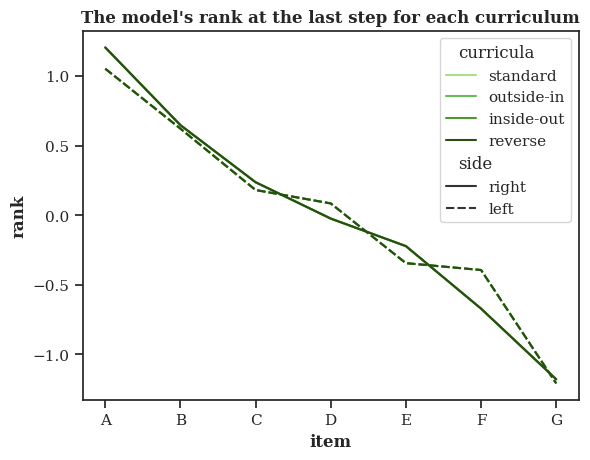

In [ ]:
title = "The model's rank at the last step for each curriculum"
wrapped_title = '\n'.join(wrap(title, 60))
fig = sns.lineplot(data = curric_rank, x = 'item', y = 'rank', hue='curricula', palette = palette3, style='side')
fig.set_title(wrapped_title, fontdict={'weight': 'bold'})
fig.set_xlabel('item', fontweight="bold")
fig.set_ylabel('rank',fontweight="bold")
plt.savefig('filename.png', dpi=1200)